# RoseTTAFold2NA Results Analysis

This notebook analyzes the output from RoseTTAFold2NA protein-DNA docking experiments.
The model produces a numpy .npz file containing three main outputs:

- **dist**: (L x L x 37) - Predicted distogram
- **lddt**: (L) - Per-residue predicted local distance difference test (confidence score)
- **pae**: (L x L) - Per-residue pair predicted aligned error

Where L is the complex length (protein + DNA).

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Load Data

Load the numpy .npz file containing the RoseTTAFold2NA predictions.

In [2]:
# Specify the path to your .npz file
# Update this path to point to your actual results file
npz_file_path = "../experiments/test_docking_20628006/models/model_00.npz"

# Check if file exists
if not Path(npz_file_path).exists():
    print(f"File not found: {npz_file_path}")
    print("Please update the npz_file_path variable to point to your actual results file.")
    print("\nExample experiment directories:")
    experiment_dir = Path("../experiments")
    if experiment_dir.exists():
        for exp in experiment_dir.iterdir():
            if exp.is_dir():
                models_dir = exp / "models"
                if models_dir.exists():
                    npz_files = list(models_dir.glob("*.npz"))
                    if npz_files:
                        print(f"  {exp.name}/models/{npz_files[0].name}")
else:
    # Load the data
    data = np.load(npz_file_path)
    print(f"Successfully loaded: {npz_file_path}")
    
    # Display available keys in the file
    print(f"\nAvailable keys in the file: {list(data.keys())}")
    
    # Extract the three main arrays
    dist = data['dist']  # Distogram (L x L x 37)
    lddt = data['lddt']  # Per-residue confidence (L)
    pae = data['pae']    # Predicted aligned error (L x L)
    
    # Print shapes
    print(f"\nData shapes:")
    print(f"  Distogram (dist): {dist.shape}")
    print(f"  LDDT confidence (lddt): {lddt.shape}")
    print(f"  Predicted Aligned Error (pae): {pae.shape}")
    
    L = len(lddt)  # Complex length
    print(f"\nComplex length (L): {L} residues")

Successfully loaded: ../experiments/test_docking_20628006/models/model_00.npz

Available keys in the file: ['dist', 'lddt', 'pae']

Data shapes:
  Distogram (dist): (223, 223, 37)
  LDDT confidence (lddt): (223,)
  Predicted Aligned Error (pae): (223, 223)

Complex length (L): 223 residues


## 1. LDDT Confidence Analysis

The Local Distance Difference Test (LDDT) provides a per-residue confidence score.
Higher values indicate higher confidence in the predicted structure.

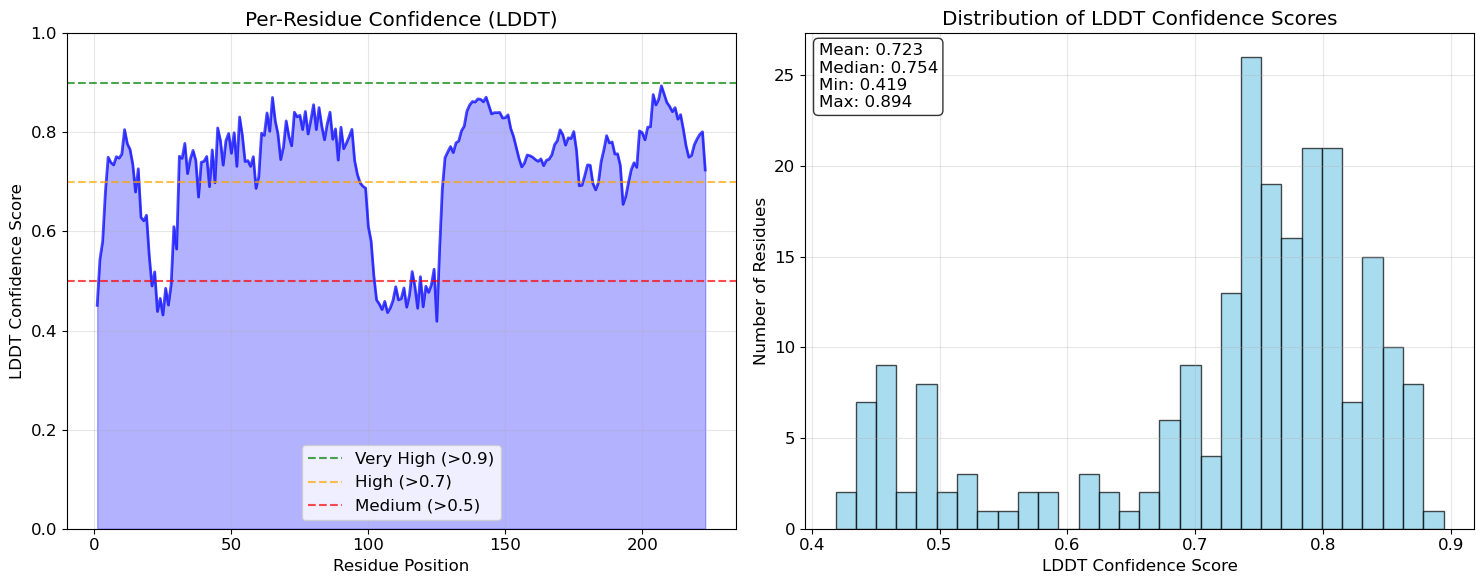

LDDT Confidence Summary:
  Mean confidence: 0.723
  Median confidence: 0.754
  Standard deviation: 0.122
  Residues with very high confidence (>0.9): 0 (0.0%)
  Residues with high confidence (>0.7): 161 (72.2%)
  Residues with low confidence (<0.5): 28 (12.6%)


In [3]:
if 'lddt' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: LDDT confidence along sequence
    ax1.plot(range(1, L+1), lddt, linewidth=2, color='blue', alpha=0.7)
    ax1.fill_between(range(1, L+1), lddt, alpha=0.3, color='blue')
    ax1.set_xlabel('Residue Position')
    ax1.set_ylabel('LDDT Confidence Score')
    ax1.set_title('Per-Residue Confidence (LDDT)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Add confidence threshold lines
    ax1.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Very High (>0.9)')
    ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, label='High (>0.7)')
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Medium (>0.5)')
    ax1.legend()
    
    # Plot 2: LDDT distribution histogram
    ax2.hist(lddt, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('LDDT Confidence Score')
    ax2.set_ylabel('Number of Residues')
    ax2.set_title('Distribution of LDDT Confidence Scores')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics text
    mean_lddt = np.mean(lddt)
    median_lddt = np.median(lddt)
    min_lddt = np.min(lddt)
    max_lddt = np.max(lddt)
    
    stats_text = f'Mean: {mean_lddt:.3f}\nMedian: {median_lddt:.3f}\nMin: {min_lddt:.3f}\nMax: {max_lddt:.3f}'
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"LDDT Confidence Summary:")
    print(f"  Mean confidence: {mean_lddt:.3f}")
    print(f"  Median confidence: {median_lddt:.3f}")
    print(f"  Standard deviation: {np.std(lddt):.3f}")
    print(f"  Residues with very high confidence (>0.9): {np.sum(lddt > 0.9)} ({100*np.sum(lddt > 0.9)/L:.1f}%)")
    print(f"  Residues with high confidence (>0.7): {np.sum(lddt > 0.7)} ({100*np.sum(lddt > 0.7)/L:.1f}%)")
    print(f"  Residues with low confidence (<0.5): {np.sum(lddt < 0.5)} ({100*np.sum(lddt < 0.5)/L:.1f}%)")

## 2. Predicted Aligned Error (PAE) Analysis

The PAE matrix shows the predicted error between pairs of residues.
Lower values (darker colors) indicate higher confidence in the relative positioning.

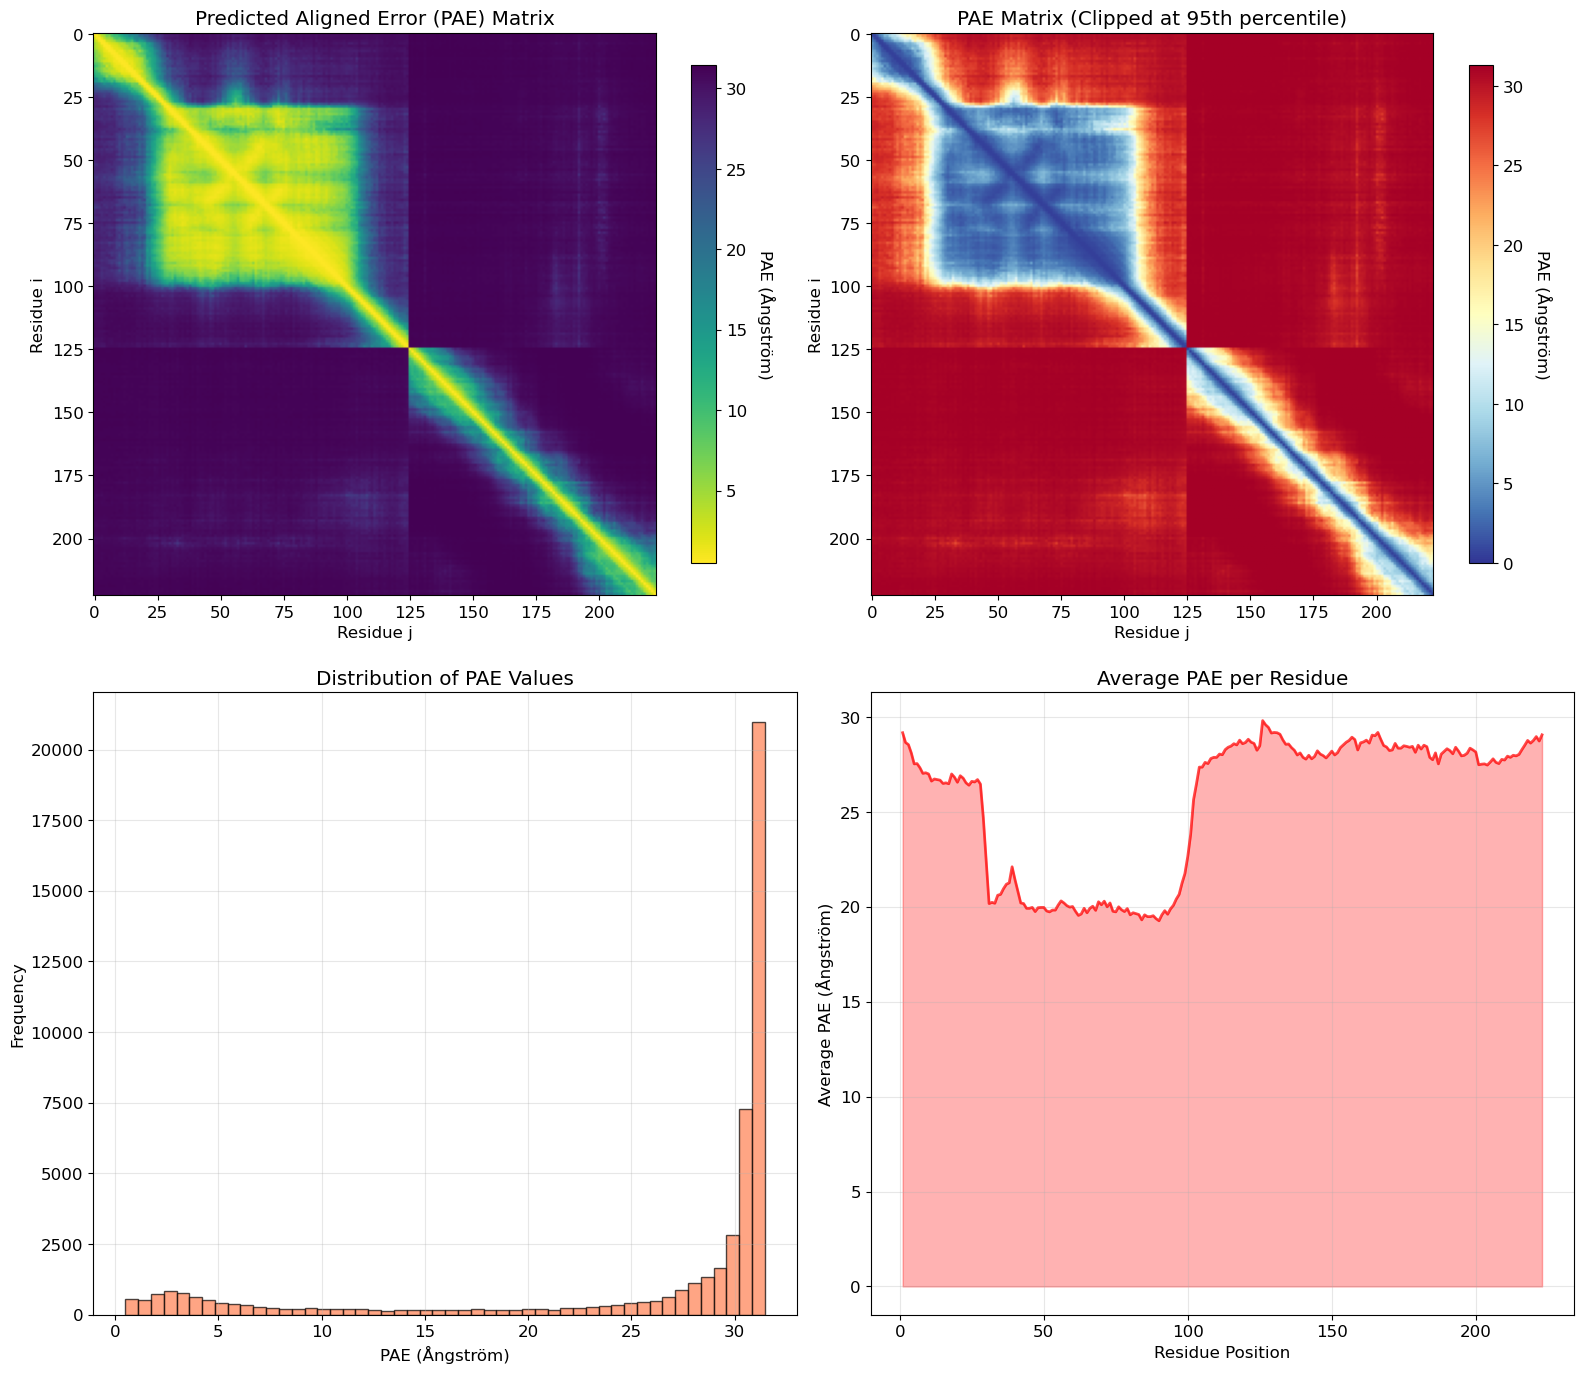

PAE Summary:
  Mean PAE: 25.50 Ångström
  Median PAE: 30.58 Ångström
  Standard deviation: inf Ångström
  Min PAE: 0.50 Ångström
  Max PAE: 31.45 Ångström
  95th percentile: 31.31 Ångström


In [4]:
if 'pae' in locals():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot 1: Full PAE heatmap
    im1 = ax1.imshow(pae, cmap='viridis_r', aspect='equal')
    ax1.set_title('Predicted Aligned Error (PAE) Matrix')
    ax1.set_xlabel('Residue j')
    ax1.set_ylabel('Residue i')
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('PAE (Ångström)', rotation=270, labelpad=20)
    
    # Plot 2: PAE with custom colormap for better interpretation
    im2 = ax2.imshow(pae, cmap='RdYlBu_r', aspect='equal', vmin=0, vmax=np.percentile(pae, 95))
    ax2.set_title('PAE Matrix (Clipped at 95th percentile)')
    ax2.set_xlabel('Residue j')
    ax2.set_ylabel('Residue i')
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('PAE (Ångström)', rotation=270, labelpad=20)
    
    # Plot 3: PAE distribution
    ax3.hist(pae.flatten(), bins=50, alpha=0.7, color='coral', edgecolor='black')
    ax3.set_xlabel('PAE (Ångström)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of PAE Values')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Average PAE per residue
    avg_pae_per_residue = np.mean(pae, axis=1)
    ax4.plot(range(1, L+1), avg_pae_per_residue, linewidth=2, color='red', alpha=0.7)
    ax4.fill_between(range(1, L+1), avg_pae_per_residue, alpha=0.3, color='red')
    ax4.set_xlabel('Residue Position')
    ax4.set_ylabel('Average PAE (Ångström)')
    ax4.set_title('Average PAE per Residue')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print PAE statistics
    mean_pae = np.mean(pae)
    median_pae = np.median(pae)
    min_pae = np.min(pae)
    max_pae = np.max(pae)
    
    print(f"PAE Summary:")
    print(f"  Mean PAE: {mean_pae:.2f} Ångström")
    print(f"  Median PAE: {median_pae:.2f} Ångström")
    print(f"  Standard deviation: {np.std(pae):.2f} Ångström")
    print(f"  Min PAE: {min_pae:.2f} Ångström")
    print(f"  Max PAE: {max_pae:.2f} Ångström")
    print(f"  95th percentile: {np.percentile(pae, 95):.2f} Ångström")

## 3. Distogram Analysis

The distogram contains predicted distance distributions for all residue pairs.
It has 37 distance bins representing different distance ranges.

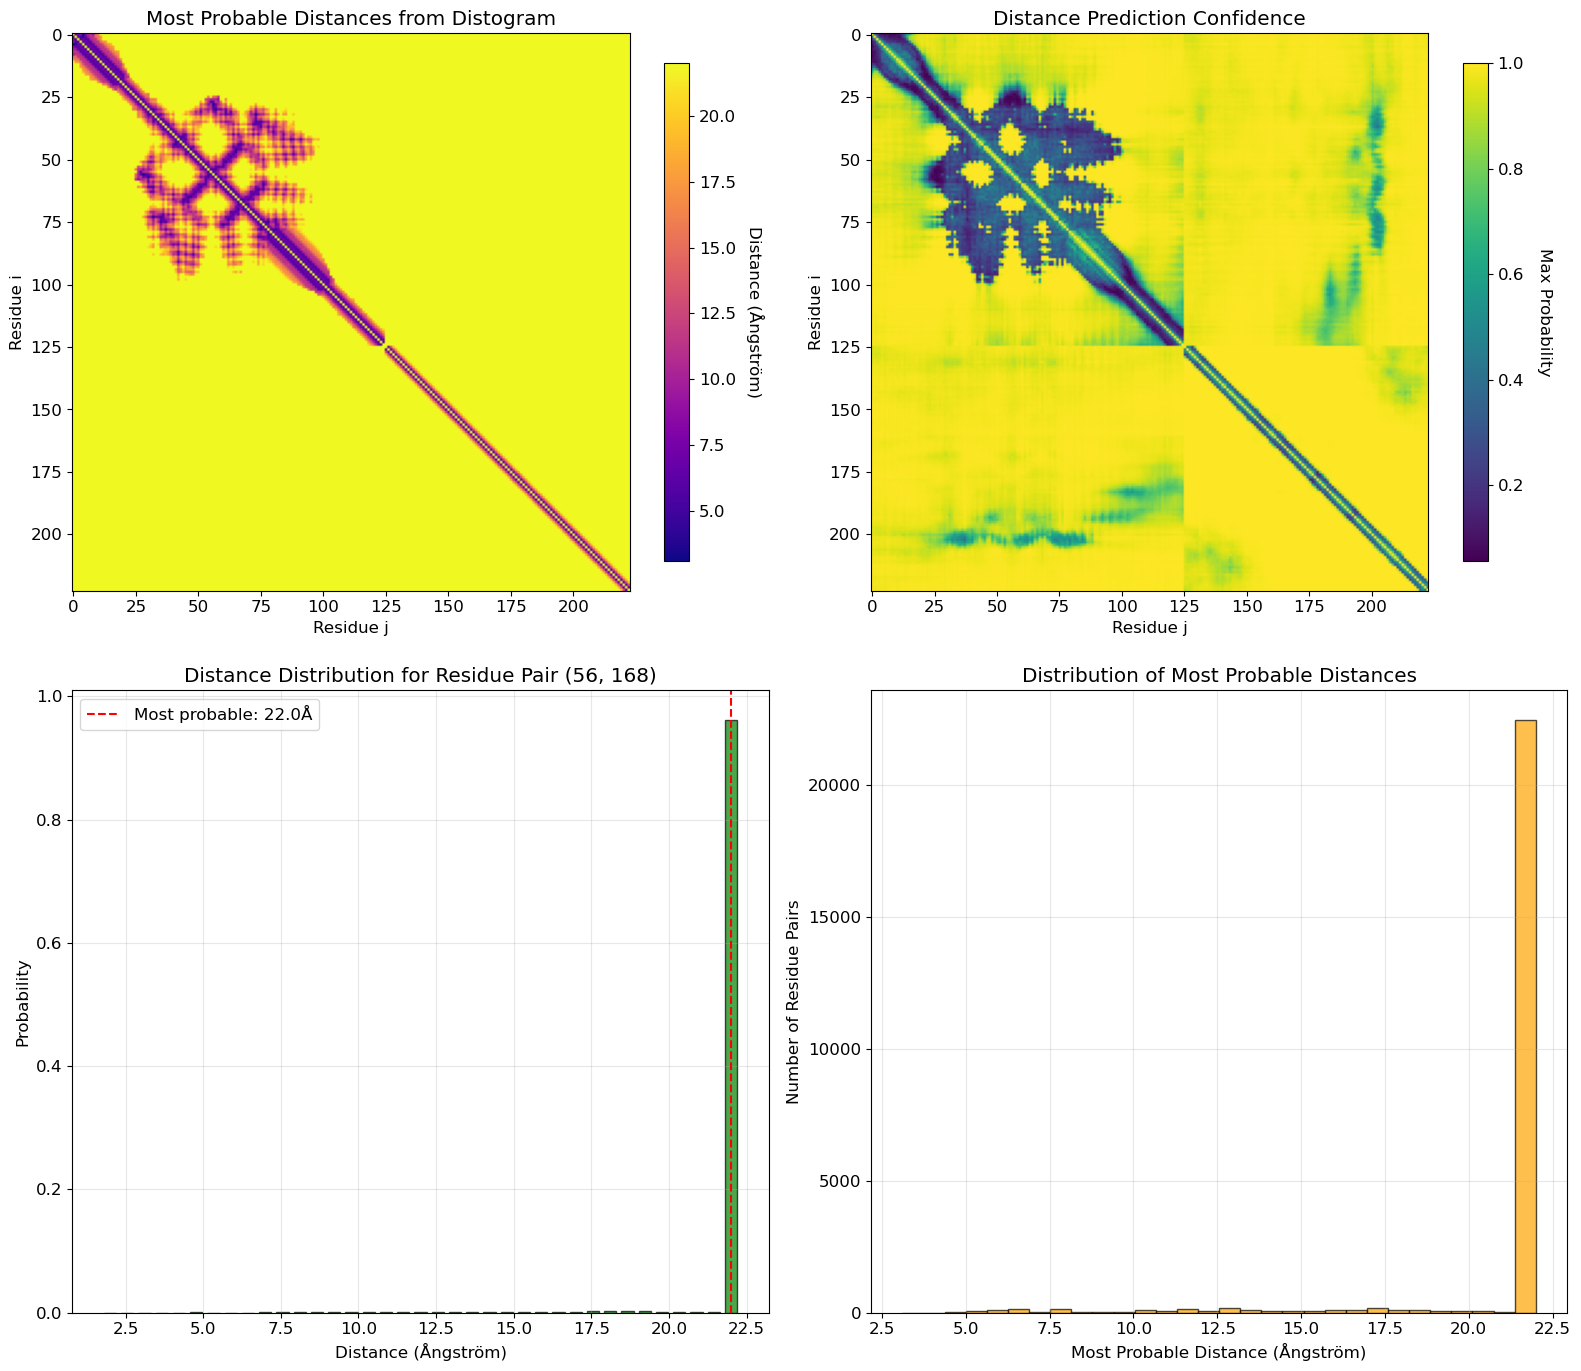

Distogram Summary:
  Mean predicted distance: 21.16 Ångström
  Median predicted distance: 22.00 Ångström
  Mean distance prediction confidence: 0.900
  Number of distance bins: 37
  Distance range: 2.0 - 22.0 Ångström


In [5]:
if 'dist' in locals():
    # Distance bins (common RoseTTAFold2NA distance bins in Ångström)
    # These are approximate bins - adjust if you know the exact binning used
    distance_bins = np.linspace(2, 22, 37)  # 37 bins from 2Å to 22Å
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot 1: Most probable distances (argmax of distogram)
    most_probable_distances = distance_bins[np.argmax(dist, axis=2)]
    im1 = ax1.imshow(most_probable_distances, cmap='plasma', aspect='equal')
    ax1.set_title('Most Probable Distances from Distogram')
    ax1.set_xlabel('Residue j')
    ax1.set_ylabel('Residue i')
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Distance (Ångström)', rotation=270, labelpad=20)
    
    # Plot 2: Confidence in distance predictions (max probability)
    distance_confidence = np.max(dist, axis=2)
    im2 = ax2.imshow(distance_confidence, cmap='viridis', aspect='equal')
    ax2.set_title('Distance Prediction Confidence')
    ax2.set_xlabel('Residue j')
    ax2.set_ylabel('Residue i')
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Max Probability', rotation=270, labelpad=20)
    
    # Plot 3: Example distance distribution for a residue pair
    # Choose a pair near the middle of the sequence
    i, j = L//4, 3*L//4
    ax3.bar(distance_bins, dist[i, j, :], alpha=0.7, color='green', edgecolor='black', width=0.4)
    ax3.set_xlabel('Distance (Ångström)')
    ax3.set_ylabel('Probability')
    ax3.set_title(f'Distance Distribution for Residue Pair ({i+1}, {j+1})')
    ax3.grid(True, alpha=0.3)
    
    # Highlight the most probable distance
    max_idx = np.argmax(dist[i, j, :])
    ax3.axvline(distance_bins[max_idx], color='red', linestyle='--', 
                label=f'Most probable: {distance_bins[max_idx]:.1f}Å')
    ax3.legend()
    
    # Plot 4: Distribution of most probable distances
    ax4.hist(most_probable_distances[np.triu_indices(L, k=1)], bins=30, 
             alpha=0.7, color='orange', edgecolor='black')
    ax4.set_xlabel('Most Probable Distance (Ångström)')
    ax4.set_ylabel('Number of Residue Pairs')
    ax4.set_title('Distribution of Most Probable Distances')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print distogram statistics
    upper_triangle = np.triu_indices(L, k=1)
    mean_distance = np.mean(most_probable_distances[upper_triangle])
    median_distance = np.median(most_probable_distances[upper_triangle])
    mean_confidence = np.mean(distance_confidence[upper_triangle])
    
    print(f"Distogram Summary:")
    print(f"  Mean predicted distance: {mean_distance:.2f} Ångström")
    print(f"  Median predicted distance: {median_distance:.2f} Ångström")
    print(f"  Mean distance prediction confidence: {mean_confidence:.3f}")
    print(f"  Number of distance bins: {dist.shape[2]}")
    print(f"  Distance range: {distance_bins[0]:.1f} - {distance_bins[-1]:.1f} Ångström")

## 4. Contact Map Analysis

Generate contact maps based on predicted distances to identify likely contacts between residues.

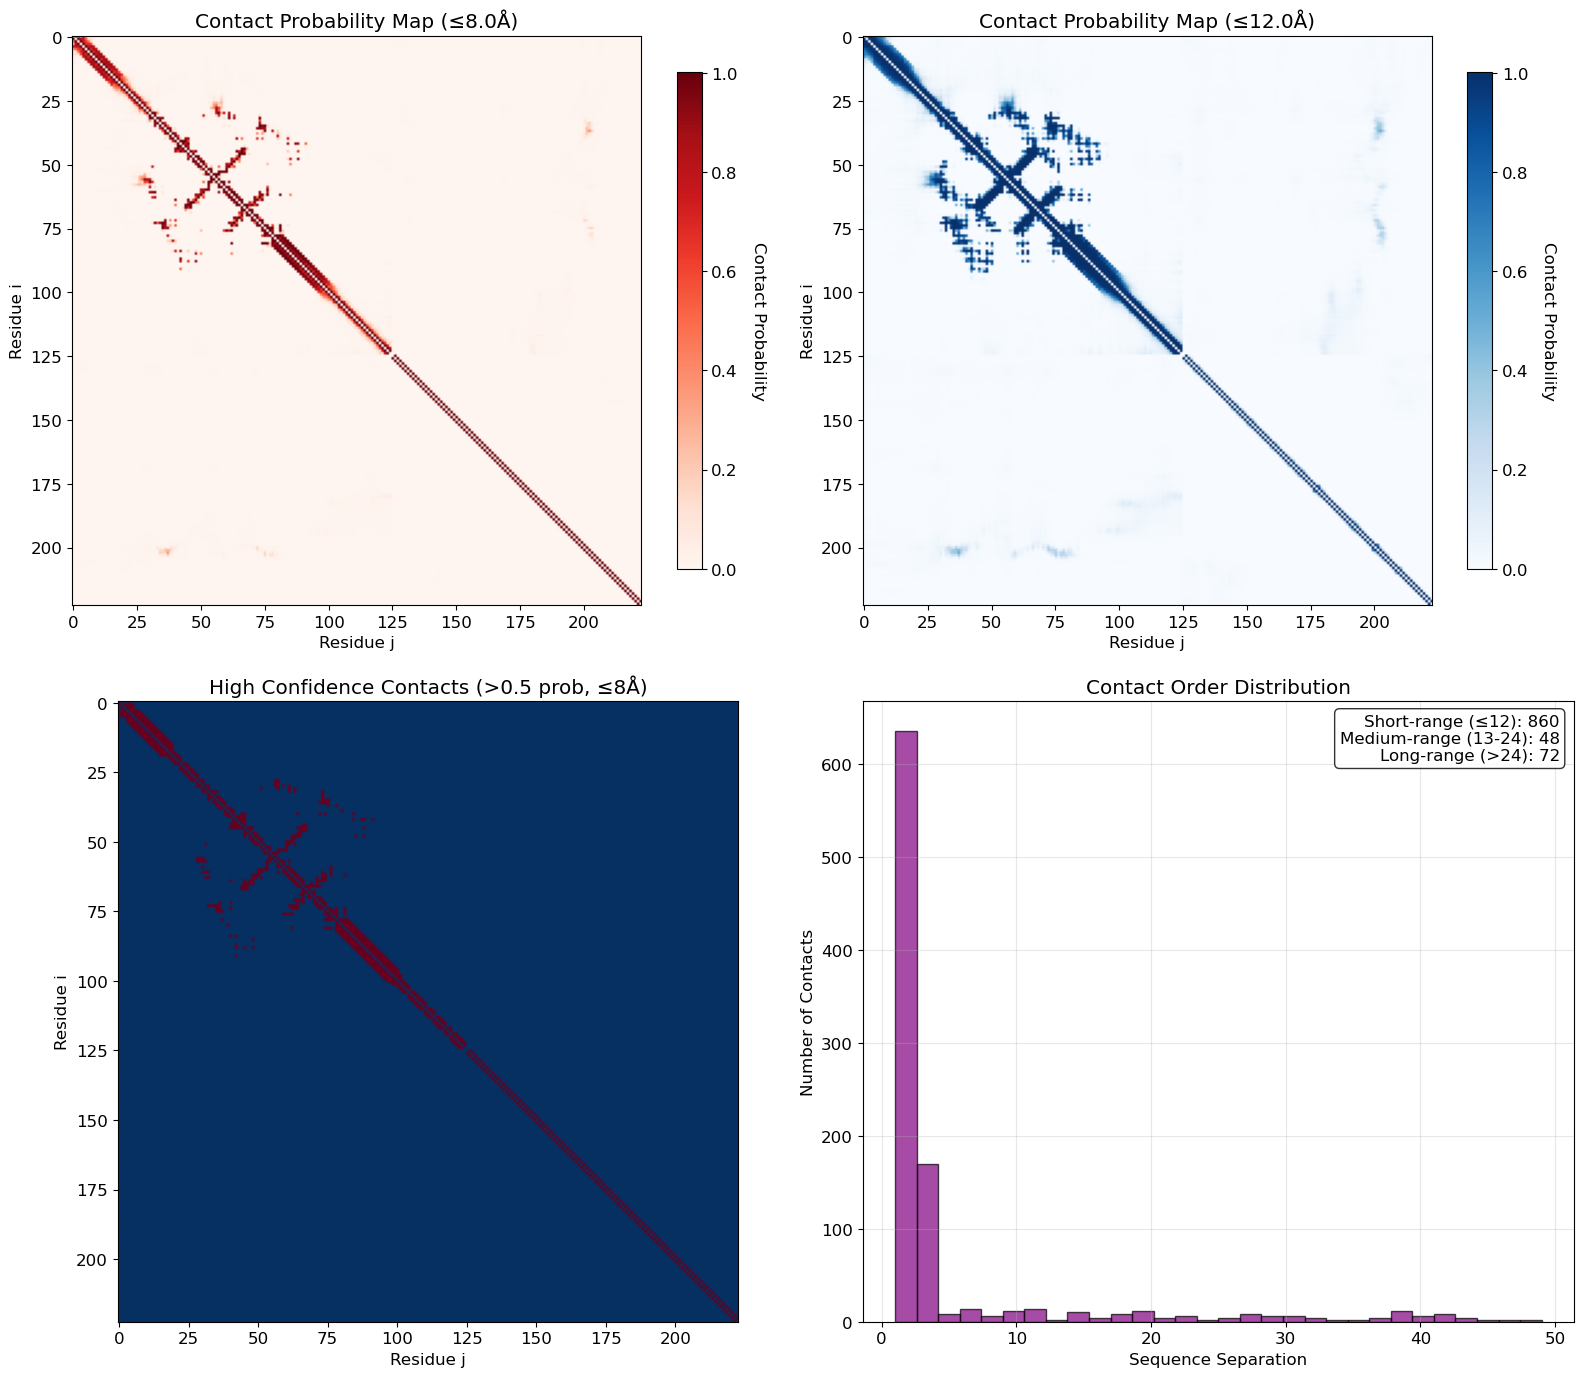

Contact Analysis Summary:
  High confidence contacts (≤8Å, >0.5 prob): 757
  Medium confidence contacts (≤12Å, >0.5 prob): 1755
  Average 8Å contact probability: 0.021
  Average 12Å contact probability: 0.045


In [6]:
if 'dist' in locals():
    # Define contact thresholds
    contact_threshold_8A = 8.0   # Strong contacts
    contact_threshold_12A = 12.0 # Medium-range contacts
    
    # Calculate contact probabilities
    # Sum probabilities for distances below threshold
    contact_prob_8A = np.sum(dist[:, :, distance_bins <= contact_threshold_8A], axis=2)
    contact_prob_12A = np.sum(dist[:, :, distance_bins <= contact_threshold_12A], axis=2)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot 1: Contact map for 8Å threshold
    im1 = ax1.imshow(contact_prob_8A, cmap='Reds', aspect='equal')
    ax1.set_title(f'Contact Probability Map (≤{contact_threshold_8A}Å)')
    ax1.set_xlabel('Residue j')
    ax1.set_ylabel('Residue i')
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Contact Probability', rotation=270, labelpad=20)
    
    # Plot 2: Contact map for 12Å threshold
    im2 = ax2.imshow(contact_prob_12A, cmap='Blues', aspect='equal')
    ax2.set_title(f'Contact Probability Map (≤{contact_threshold_12A}Å)')
    ax2.set_xlabel('Residue j')
    ax2.set_ylabel('Residue i')
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Contact Probability', rotation=270, labelpad=20)
    
    # Plot 3: Binary contact map (high confidence contacts)
    high_confidence_contacts = (contact_prob_8A > 0.5) & (np.arange(L)[:, None] != np.arange(L))
    ax3.imshow(high_confidence_contacts, cmap='RdBu_r', aspect='equal')
    ax3.set_title('High Confidence Contacts (>0.5 prob, ≤8Å)')
    ax3.set_xlabel('Residue j')
    ax3.set_ylabel('Residue i')
    
    # Plot 4: Contact order analysis
    # Calculate sequence separation for contacts
    contact_pairs = np.where(high_confidence_contacts)
    if len(contact_pairs[0]) > 0:
        sequence_separations = np.abs(contact_pairs[0] - contact_pairs[1])
        ax4.hist(sequence_separations, bins=30, alpha=0.7, color='purple', edgecolor='black')
        ax4.set_xlabel('Sequence Separation')
        ax4.set_ylabel('Number of Contacts')
        ax4.set_title('Contact Order Distribution')
        ax4.grid(True, alpha=0.3)
        
        # Add statistics
        short_range = np.sum(sequence_separations <= 12)
        medium_range = np.sum((sequence_separations > 12) & (sequence_separations <= 24))
        long_range = np.sum(sequence_separations > 24)
        
        ax4.text(0.98, 0.98, f'Short-range (≤12): {short_range}\n' + 
                            f'Medium-range (13-24): {medium_range}\n' + 
                            f'Long-range (>24): {long_range}',
                transform=ax4.transAxes, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax4.text(0.5, 0.5, 'No high confidence contacts found', 
                transform=ax4.transAxes, ha='center', va='center')
        ax4.set_title('Contact Order Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print contact statistics
    total_contacts_8A = np.sum(contact_prob_8A > 0.5) - L  # Subtract diagonal
    total_contacts_12A = np.sum(contact_prob_12A > 0.5) - L
    
    print(f"Contact Analysis Summary:")
    print(f"  High confidence contacts (≤8Å, >0.5 prob): {total_contacts_8A}")
    print(f"  Medium confidence contacts (≤12Å, >0.5 prob): {total_contacts_12A}")
    print(f"  Average 8Å contact probability: {np.mean(contact_prob_8A[contact_prob_8A > 0]):.3f}")
    print(f"  Average 12Å contact probability: {np.mean(contact_prob_12A[contact_prob_12A > 0]):.3f}")